In [1]:
# Exploratory analysis for Pisa Traffic & Urban Map

import pandas as pd
import numpy as np

from shapely import wkb
from shapely.geometry import mapping
from shapely.ops import transform as shapely_transform

from pyproj import Transformer

import folium
import matplotlib.pyplot as plt


In [ ]:
# This cell loads all parquet datasets used by the application.
# Input: parquet files from the ../data directory.
# Output: buildings_df, roads_df, traffic_df as pandas DataFrames.

DATA_DIR = "data"

buildings_df = pd.read_parquet(f"{DATA_DIR}/BUILDINGS_GEOM_v1.parquet")
roads_df     = pd.read_parquet(f"{DATA_DIR}/GEOM_V1.parquet")
traffic_df   = pd.read_parquet(f"{DATA_DIR}/traffic_res.parquet")

print("Buildings shape:", buildings_df.shape)
print("Roads shape    :", roads_df.shape)
print("Traffic shape  :", traffic_df.shape)

print("\nBuildings columns:", list(buildings_df.columns))
print("Roads columns    :", list(roads_df.columns))
print("Traffic columns  :", list(traffic_df.columns))


Buildings shape: (1931, 4)
Roads shape    : (8048, 3)
Traffic shape  : (19335, 21)

Buildings columns: ['PK', 'HEIGHT', 'POP', 'geometry']
Roads columns    : ['PK', 'id', 'geometry']
Traffic columns  : ['arrived', 'density', 'departed', 'entered', 'id', 'laneChangedFrom', 'laneChangedTo', 'laneDensity', 'left', 'occupancy', 'overlapTraveltime', 'sampledSeconds', 'speed', 'speedRelative', 'timeLoss', 'traveltime', 'waitingTime', 'vclass', 'preloading', 'begin', 'end']


In [3]:
# This cell runs basic sanity checks on the main tables.
# Input: buildings_df, roads_df, traffic_df.
# Output: printed summaries: heads, null counts, basic stats.

print("=== Buildings sample ===")
display(buildings_df.head(3))
print("\nMissing values (Buildings):")
display(buildings_df.isna().sum())

print("\n=== Roads sample ===")
display(roads_df.head(3))
print("\nMissing values (Roads):")
display(roads_df.isna().sum())

print("\n=== Traffic sample ===")
display(traffic_df.head(3))
print("\nMissing values (Traffic):")
display(traffic_df.isna().sum())


=== Buildings sample ===


PK  HEIGHT   POP                                           geometry
0   1     7.7  12.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x15\x00...
1   2     3.0   0.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
2   3     7.8   3.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...


Missing values (Buildings):


PK          0
HEIGHT      0
POP         0
geometry    0
dtype: int64


=== Roads sample ===


PK              id                                           geometry
0   1  :10095708242_0  b'\x01\xea\x03\x00\x00\x02\x00\x00\x00e\xf7%0\...
1   2  :10095708242_1  b'\x01\xea\x03\x00\x00\x03\x00\x00\x00e\xf7%0\...
2   3  :10095708242_6  b'\x01\xea\x03\x00\x00\x04\x00\x00\x00z\x1d\xb...


Missing values (Roads):


PK          0
id          0
geometry    0
dtype: int64


=== Traffic sample ===


arrived  density  departed  entered             id  laneChangedFrom  \
0      0.0     0.73       0.0      1.0  :1942944427_0              0.0   
1      0.0     0.37       0.0      1.0  :1942989937_1              0.0   
2      0.0     0.92       0.0      1.0  :1942989938_0              0.0   

   laneChangedTo  laneDensity  left  occupancy  ...  sampledSeconds  speed  \
0            0.0         0.73   1.0       0.34  ...            3.14   6.84   
1            0.0         0.37   1.0       0.16  ...            1.11  15.30   
2            0.0         0.92   1.0       0.32  ...            1.90   7.37   

   speedRelative  timeLoss  traveltime  waitingTime    vclass preloading  \
0           0.82      0.22        2.13          0.0  HV_truck      False   
1           0.79      0.06        0.64          0.0  HV_truck      False   
2           0.66      0.18        0.87          0.0  HV_truck      False   

                begin                 end  
0 2025-03-24 06:00:00 2025-03-24 06:05:00  
1 2025-03-24 06:00:00 2025-03-24 06:05:00  
2 2025-03-24 06:00:00 2025-03-24 06:05:00  

[3 rows x 21 columns]


Missing values (Traffic):


arrived              0
density              0
departed             0
entered              0
id                   0
laneChangedFrom      0
laneChangedTo        0
laneDensity          0
left                 0
occupancy            0
overlapTraveltime    0
sampledSeconds       0
speed                0
speedRelative        0
timeLoss             0
traveltime           0
waitingTime          0
vclass               0
preloading           0
begin                0
end                  0
dtype: int64

In [4]:
from typing import Any, Optional

def parse_wkb_geometry(value: Any):
    """
    Convert WKB bytes into a shapely geometry.
    Input: value (WKB bytes or None).
    Output: shapely geometry or None on failure.
    """
    if value is None:
        return None
    try:
        return wkb.loads(value)
    except Exception:
        return None

buildings_df["geometry_obj"] = buildings_df["geometry"].apply(parse_wkb_geometry)
roads_df["geometry_obj"]     = roads_df["geometry"].apply(parse_wkb_geometry)



In [5]:
buildings_df

PK  HEIGHT   POP                                           geometry  \
0        1     7.7  12.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x15\x00...   
1        2     3.0   0.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...   
2        3     7.8   3.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...   
3        4    10.8   6.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00...   
4        5     9.0   2.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x...   
...    ...     ...   ...                                                ...   
1926  3970     2.0   0.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...   
1927  3971     2.3   0.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...   
1928  3973     7.8   5.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x...   
1929  3974     7.2   5.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x...   
1930  3975     2.3   0.0  b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...   

                                           geometry_obj  
0     POLYGON ((1602732.87 4836001.58, 1602743.6 483...  
1     POLYGON ((1602762.1 4835977.66, 1602776.78 483...  
2     POLYGON ((1602759.42 4836016.55, 1602773.44 48...  
3     POLYGON ((1602719.04 4836031.71, 1602734.04 48...  
4     POLYGON ((1602742.57 4836037.56, 1602747.71 48...  
...                                                 ...  
1926  POLYGON ((1610155.55 4838391.65, 1610156.09 48...  
1927  POLYGON ((1610176.43 4838392.15, 1610176.78 48...  
1928  POLYGON ((1610272.48 4838399.89, 1610273.14 48...  
1929  POLYGON ((1610237.99 4838401.81, 1610238.64 48...  
1930  POLYGON ((1610302.33 4838406.41, 1610302.4 483...  

[1931 rows x 5 columns]

In [6]:
roads_df

PK              id                                           geometry  \
0        1  :10095708242_0  b'\x01\xea\x03\x00\x00\x02\x00\x00\x00e\xf7%0\...   
1        2  :10095708242_1  b'\x01\xea\x03\x00\x00\x03\x00\x00\x00e\xf7%0\...   
2        3  :10095708242_6  b'\x01\xea\x03\x00\x00\x04\x00\x00\x00z\x1d\xb...   
3        4  :10095708242_2  b'\x01\xea\x03\x00\x00\x05\x00\x00\x00\xd8\x8a...   
4        5  :10095708242_3  b'\x01\xea\x03\x00\x00\x05\x00\x00\x00\xd8\x8a...   
...    ...             ...                                                ...   
8043  8044      97982685#1  b'\x01\xea\x03\x00\x00\x03\x00\x00\x00\x02S\x9...   
8044  8045      97982685#2  b'\x01\xea\x03\x00\x00\x03\x00\x00\x00AUN%S~8A...   
8045  8046      97982685#3  b'\x01\xea\x03\x00\x00\x03\x00\x00\x00%\xb1r\x...   
8046  8047              E0  b'\x01\xea\x03\x00\x00\x02\x00\x00\x00\x1b5D*\...   
8047  8048              E1  b'\x01\xea\x03\x00\x00\x02\x00\x00\x00I\xe6m\x...   

                                           geometry_obj  
0     LINESTRING Z (1603974.188079321 4837079.012769...  
1     LINESTRING Z (1603974.188079321 4837079.012769...  
2     LINESTRING Z (1603970.8935411857 4837078.29501...  
3     LINESTRING Z (1603970.9815756585 4837072.63069...  
4     LINESTRING Z (1603970.9815756585 4837072.63069...  
...                                                 ...  
8043  LINESTRING Z (1605057.1390735512 4831976.81513...  
8044  LINESTRING Z (1605203.145726517 4832071.867454...  
8045  LINESTRING Z (1605268.8142500606 4832113.66949...  
8046  LINESTRING Z (1603317.165103263 4834843.341872...  
8047  LINESTRING Z (1603333.978239434 4834851.377752...  

[8048 rows x 4 columns]

In [7]:
from pyproj import Transformer
from shapely.ops import transform as shapely_transform

# Candidate CRS to test (common for Italy/Europe)
CANDIDATE_CRS = [
    "EPSG:3003",   # Monte Mario / Italy zone 1
    "EPSG:3004",   # Monte Mario / Italy zone 2
    "EPSG:32632",  # WGS84 / UTM zone 32N
    "EPSG:32633",  # WGS84 / UTM zone 33N
    "EPSG:25832",  # ETRS89 / UTM zone 32N
    "EPSG:25833",  # ETRS89 / UTM zone 33N
    "EPSG:3857",   # Web Mercator
    "EPSG:4326",   # Already WGS84
]


def is_in_pisa_region(lon: float, lat: float) -> bool:
    """
    Check if a point falls in a broad Pisa region.
    Input: lon, lat in WGS84 degrees.
    Output: True if inside region, else False.
    """
    if not (np.isfinite(lon) and np.isfinite(lat)):
        return False
    # Loose box around Pisa and surroundings (Tuscany coast area)
    return (9.5 <= lon <= 11.5) and (42.5 <= lat <= 44.5)


def test_crs_on_sample(df, geom_col: str, crs_code: str, sample_size: int = 200):
    """
    Test how many sample geometries land in Pisa region after transform.
    Input: DataFrame, geometry column name, CRS code string.
    Output: (total_tested, valid_points, in_pisa_region_count).
    """
    try:
        transformer = Transformer.from_crs(crs_code, "EPSG:4326", always_xy=True)
    except Exception:
        return 0, 0, 0

    sample = df[geom_col].dropna().head(sample_size)
    if sample.empty:
        return 0, 0, 0

    total = 0
    valid = 0
    pisa_count = 0

    for geom in sample:
        try:
            g2 = shapely_transform(transformer.transform, geom)
            cx, cy = g2.centroid.x, g2.centroid.y  # lon, lat
            total += 1
            if np.isfinite(cx) and np.isfinite(cy):
                valid += 1
                if is_in_pisa_region(cx, cy):
                    pisa_count += 1
        except Exception:
            total += 1

    return total, valid, pisa_count


def pick_best_crs(df, geom_col: str):
    """
    Pick CRS with highest fraction of points inside Pisa region.
    Input: DataFrame with geometries, geometry column name.
    Output: (best_crs_code, score_dict_per_crs).
    """
    results = {}
    best = None
    best_ratio = -1.0

    for crs in CANDIDATE_CRS:
        total, valid, pisa_count = test_crs_on_sample(df, geom_col, crs)
        ratio = (pisa_count / valid) if valid > 0 else 0.0
        results[crs] = {
            "total": int(total),
            "valid": int(valid),
            "pisa_count": int(pisa_count),
            "pisa_ratio": float(ratio),
        }
        if valid > 0 and ratio > best_ratio:
            best = crs
            best_ratio = ratio

    return best, results


# ---- Run CRS detection on buildings ----
best_crs, crs_scores = pick_best_crs(buildings_df, "geometry_obj")

print("CRS scoring (based on buildings centroids in Pisa region):")
for crs, r in crs_scores.items():
    print(
        f"{crs}: total={r['total']}, valid={r['valid']}, "
        f"pisa_count={r['pisa_count']}, pisa_ratio={r['pisa_ratio']:.2f}"
    )

if best_crs is None:
    print("\nNo clear winner, falling back to EPSG:3003 by assumption.")
    best_crs = "EPSG:3003"

print("\nSelected CRS for this dataset:", best_crs)

# ---- Use selected CRS for final transform ----
transformer_to_wgs84 = Transformer.from_crs(best_crs, "EPSG:4326", always_xy=True)


def convert_geometry_to_wgs84(geometry):
    """
    Convert geometry from chosen CRS to WGS84.
    Input: shapely geometry or None.
    Output: transformed geometry or original if error.
    """
    if geometry is None:
        return None
    try:
        return shapely_transform(transformer_to_wgs84.transform, geometry)
    except Exception:
        return geometry


buildings_df["geometry_wgs84"] = buildings_df["geometry_obj"].apply(convert_geometry_to_wgs84)
roads_df["geometry_wgs84"]     = roads_df["geometry_obj"].apply(convert_geometry_to_wgs84)

print("\nExample building bounds (WGS84):", buildings_df["geometry_wgs84"].dropna().iloc[0].bounds)
print("Example road bounds (WGS84):", roads_df["geometry_wgs84"].dropna().iloc[0].bounds)


CRS scoring (based on buildings centroids in Pisa region):
EPSG:3003: total=200, valid=200, pisa_count=200, pisa_ratio=1.00
EPSG:3004: total=200, valid=200, pisa_count=0, pisa_ratio=0.00
EPSG:32632: total=200, valid=200, pisa_count=0, pisa_ratio=0.00
EPSG:32633: total=200, valid=200, pisa_count=0, pisa_ratio=0.00
EPSG:25832: total=200, valid=200, pisa_count=0, pisa_ratio=0.00
EPSG:25833: total=200, valid=200, pisa_count=0, pisa_ratio=0.00
EPSG:3857: total=200, valid=200, pisa_count=0, pisa_ratio=0.00
EPSG:4326: total=200, valid=200, pisa_count=0, pisa_ratio=0.00

Selected CRS for this dataset: EPSG:3003

Example building bounds (WGS84): (10.273962892485763, 43.66933036084273, 10.274636628382126, 43.669822713516176)
Example road bounds (WGS84): (10.289446002661059, 43.67930700140137, 10.28956400266103, 43.679308001401395)


In [8]:
def dataframe_to_geojson(df: pd.DataFrame, geometry_column: str, property_columns):
    """
    Build a GeoJSON FeatureCollection from a DataFrame.
    Input: df (DataFrame), geometry_column (str), property_columns (list of column names).
    Output: dict with type='FeatureCollection' and list of features.
    """
    features = []

    for _, row in df.iterrows():
        geom = row[geometry_column]
        if geom is None:
            continue

        feature = {
            "type": "Feature",
            "geometry": mapping(geom),
            "properties": {col: row.get(col) for col in property_columns}
        }
        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features,
    }

buildings_geojson = dataframe_to_geojson(
    buildings_df,
    geometry_column="geometry_wgs84",
    property_columns=["PK", "HEIGHT", "POP"]
)

roads_geojson = dataframe_to_geojson(
    roads_df,
    geometry_column="geometry_wgs84",
    property_columns=["PK", "id"]
)

print("Buildings features:", len(buildings_geojson["features"]))
print("Roads features    :", len(roads_geojson["features"]))


Buildings features: 1931
Roads features    : 8048


In [9]:
def create_quick_map(buildings_fc: dict, roads_fc: dict):
    """
    Create a small folium map for a quick spatial sanity check.
    Input: buildings_fc and roads_fc as GeoJSON FeatureCollections.
    Output: folium.Map object centered on data.
    """
    all_coords = []

    for feature in buildings_fc["features"][:200]:
        coords = feature["geometry"]["coordinates"]
        if feature["geometry"]["type"] == "Polygon":
            all_coords.extend(coords[0])
        elif feature["geometry"]["type"] == "Point":
            all_coords.append(coords)

    for feature in roads_fc["features"][:500]:
        if feature["geometry"]["type"] == "LineString":
            all_coords.extend(feature["geometry"]["coordinates"])

    if all_coords:
        lons = [c[0] for c in all_coords]
        lats = [c[1] for c in all_coords]
        center = [np.mean(lats), np.mean(lons)]
    else:
        center = [43.7167, 10.3967]  # Pisa fallback

    m = folium.Map(location=center, zoom_start=13)

    folium.GeoJson(roads_fc, name="Roads",
                   style_function=lambda x: {"color": "#2563eb", "weight": 2}).add_to(m)

    folium.GeoJson(buildings_fc, name="Buildings",
                   style_function=lambda x: {"color": "#10b981", "weight": 1, "fillOpacity": 0.4}).add_to(m)

    folium.LayerControl().add_to(m)
    return m

quick_map = create_quick_map(buildings_geojson, roads_geojson)
quick_map


In [10]:
# This cell inspects traffic data coverage and key fields.
# Input: traffic_df.
# Output: printed summary of time range, vclass distribution, and some stats.

print("Traffic date range (raw):")
if "begin" in traffic_df.columns and "end" in traffic_df.columns:
    print("  min begin:", traffic_df["begin"].min())
    print("  max end  :", traffic_df["end"].max())

if "vclass" in traffic_df.columns:
    print("\nTop vclass values:")
    display(traffic_df["vclass"].value_counts().head(10))


Traffic date range (raw):
  min begin: 2025-03-24 06:00:00
  max end  : 2025-03-24 07:00:00

Top vclass values:


vclass
LMV_passenger    13531
HV_truck          2544
MHV_delivery      1981
PWA_moped         1279
Name: count, dtype: int64

In [13]:
traffic_df['vehicles_row'] = (traffic_df['entered'].fillna(0) + traffic_df['left'].fillna(0))/2

cnt = traffic_df.pivot_table(
        index=["id", "begin", "end"],
        columns="vclass",
        values="vehicles_row",
        aggfunc="sum",
        fill_value=0,
    )
def attach_road_geometry(traffic_table: pd.DataFrame, roads: pd.DataFrame):
    """
    Attach road geometry to traffic rows using road id.
    Input: traffic_table with 'id', roads with 'id' and 'geometry_wgs84'.
    Output: merged DataFrame with 'geometry_wgs84' per traffic row (when available).
    """
    geom_by_id = dict(zip(roads["id"], roads["geometry_wgs84"]))
    result = traffic_table.copy()
    result["geometry_wgs84"] = result["id"].map(geom_by_id)
    return result

if "vclass" in traffic_df.columns:
    cnt_reset = cnt.reset_index()
    traffic_with_geom = attach_road_geometry(cnt_reset, roads_df)
    display(traffic_with_geom.head())


vclass           id               begin                 end  HV_truck  \
0       -1029426905 2025-03-24 06:10:00 2025-03-24 06:15:00       0.0   
1       -1029426905 2025-03-24 06:15:00 2025-03-24 06:20:00       0.0   
2       -1029426905 2025-03-24 06:20:00 2025-03-24 06:25:00       0.0   
3       -1029426905 2025-03-24 06:25:00 2025-03-24 06:30:00       0.0   
4       -1029426905 2025-03-24 06:30:00 2025-03-24 06:35:00       0.0   

vclass  LMV_passenger  MHV_delivery  PWA_moped  \
0                 0.0           0.0        0.0   
1                 0.0           0.0        0.0   
2                 0.0           0.0        0.0   
3                 0.5           0.0        0.0   
4                 0.0           0.0        0.0   

vclass                                     geometry_wgs84  
0       LINESTRING Z (10.356455002648316 43.6927120013...  
1       LINESTRING Z (10.356455002648316 43.6927120013...  
2       LINESTRING Z (10.356455002648316 43.6927120013...  
3       LINESTRING Z (10.356455002648316 43.6927120013...  
4       LINESTRING Z (10.356455002648316 43.6927120013...

In [14]:
# This cell finds top busy segments to understand traffic distribution.
# Input: traffic_df with vehicles_row.
# Output: printed sample of busiest road segments.

if "vehicles_row" in traffic_df.columns:
    grouped = (
        traffic_df.groupby("id")["vehicles_row"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    print("Top 10 busiest road segments by total vehicles_row:")
    display(grouped)


Top 10 busiest road segments by total vehicles_row:


id
590452906        100.0
500750406         94.5
1074262831#0      94.0
:1942989938_0     94.0
:251344924_1      94.0
1074262831#1      94.0
1074262831#2      94.0
-527564037        93.5
-890936749        92.0
:2526289977_1     92.0
Name: vehicles_row, dtype: float64

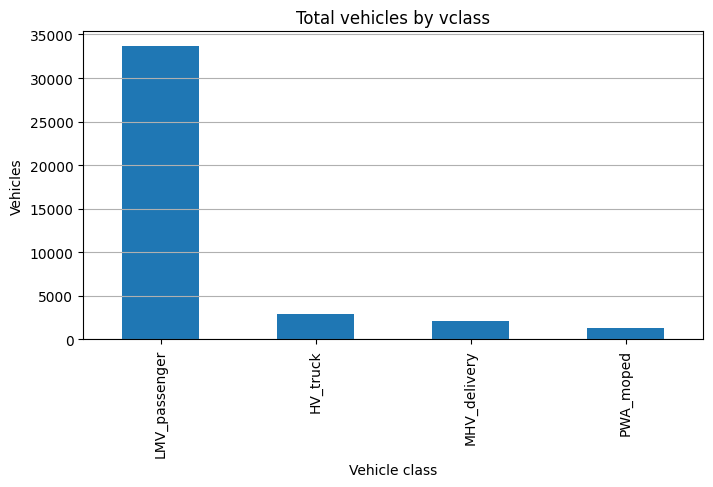

In [15]:
# This cell creates a couple of simple plots to visualize traffic patterns.
# Input: traffic_df with begin, vehicles_row, vclass.
# Output: Matplotlib charts (if enough data).

traffic_plot = traffic_df.copy()


if "vclass" in traffic_plot.columns:
    plt.figure(figsize=(8, 4))
    (
        traffic_plot.groupby("vclass")["vehicles_row"]
        .sum()
        .sort_values(ascending=False)
        .plot(kind="bar")
    )
    plt.title("Total vehicles by vclass")
    plt.xlabel("Vehicle class")
    plt.ylabel("Vehicles")
    plt.grid(axis="y")
    plt.show()


In [16]:
# This cell explains how this notebook connects to the backend code.
# Input: None (explanatory).
# Output: Markdown-style explanation printed in the notebook.

from textwrap import dedent

print(dedent("""
Link to production implementation:

- The geometry parsing and EPSG:3003 → EPSG:4326 conversion logic here
  is implemented in `server/geometry_utils.py`.

- The traffic aggregation ideas:
    - row-level vehicle counts,
    - weighted mean speeds by vehicle class,
    - segment-level aggregation,
    - (in the app) 95th percentile baseline for relative speed,
  are implemented in `server/traffic_processing.py`.

- The GeoJSON constructions and use of road geometries
  are implemented in `server/roads_cache.py` and `server/api_endpoints.py`.

This notebook is the 'data-first' step:
understand the data → validate assumptions → design metrics →
then move the stable logic into the application code.
"""))



Link to production implementation:

- The geometry parsing and EPSG:3003 → EPSG:4326 conversion logic here
  is implemented in `server/geometry_utils.py`.

- The traffic aggregation ideas:
    - row-level vehicle counts,
    - weighted mean speeds by vehicle class,
    - segment-level aggregation,
    - (in the app) 95th percentile baseline for relative speed,
  are implemented in `server/traffic_processing.py`.

- The GeoJSON constructions and use of road geometries
  are implemented in `server/roads_cache.py` and `server/api_endpoints.py`.

This notebook is the 'data-first' step:
understand the data → validate assumptions → design metrics → 
then move the stable logic into the application code.

